# Collating XML with embedded markup

This notebook illustrates one strategy for collating XML with embedded markup. It flattens the markup into milestones and retains the milestones in the "t" values and the output, while ignoring them in the "n" values for collation purposes. This ignores markup for collation purposes, but retains it (transformed) in the output, which may or may not be what you want. It is not possible to retain the original element structure completely unchanged because elements may begin in the middle of a word token, which invites an overlap conflict. Flattening the original markup is one strategy for negotiating the conflict.

## The challenge

The principal challenge involves tokenizing the input into words for collation purposes while avoiding overlap. For example, if the input includes the following:

```xml
<p>Cur<hi rend="underline">ly Lar</hi>ry Moe</p>
```

there are three word tokens: “Curly”, “Larry”, “Moe”. But because the `<hi>` start tag is in the middle of the first word and the matching end tag is in the middle of the second, it isn’t possible simply to wrap the words in `<w>` tags (never mind the challenges of tokenizing mixed content in the first place). The problem is that the XML model doesn’t match the task because in the XML model the three names are not *content objects*, that is, element or `text()` nodes. The only reason we don’t see the overlap until we try to convert the pseudo-markup into real markup is because its implicit nature disguises the reality. 

## The data

The input in this example consists of the four sample files (in the `witnesses` subdirectory), which are valid (if also vapid) TEI. Here’s one example:

### `witnessA.xml`

```xml
<?xml version="1.0" encoding="UTF-8"?>
<?xml-model href="http://www.tei-c.org/release/xml/tei/custom/schema/relaxng/tei_all.rng" type="application/xml" schematypens="http://relaxng.org/ns/structure/1.0"?>
<?xml-model href="http://www.tei-c.org/release/xml/tei/custom/schema/relaxng/tei_all.rng" type="application/xml"
	schematypens="http://purl.oclc.org/dsdl/schematron"?>
<TEI xmlns="http://www.tei-c.org/ns/1.0">
   <teiHeader>
      <fileDesc>
         <titleStmt>
            <title>Title</title>
         </titleStmt>
         <publicationStmt>
            <p>Publication Information</p>
         </publicationStmt>
         <sourceDesc>
            <p>Information about the source</p>
         </sourceDesc>
      </fileDesc>
   </teiHeader>
   <text>
      <body>
         <p>This is the first paragraph.</p>
         <p>This is <subst><add>the</add><del>a</del></subst> sec<add>ond</add> paragraph.</p>
      </body>
   </text>
</TEI>```

In human terms, the second paragraph reads something like:

> This is **the second** paragraph.

except that “the” has been added as a replacement for “a” and the last three letters of “second” have been inserted. that is, the original version read something like:

> This is **a sec** paragraph.

We pass these four files through three XSLT transformation before letting python perform the collation. We use XSLT because python support for complex XML processing is limited. The only XML-idiomatic of the major python libraries, `lxml`, supports only XSLT 1.0, and `pulldom` doesn’t even know how to distinguish significant and insignificant white space. It is possible to do all of the processing within python using either of these libraries, but awareness of white-space significance plus features available in XSLT 2.0, such as `tokenize()`, `<xsl:analyze-string>`, and `<xsl:for-each-group>`, make XSLT 2.0 processing more idiomatic than the python alternatives.

In Real Life we would probably combine the three XSLT transformations into one to avoid the overhead of launching new java processes for each step in the pipeline. We have separated the steps here to make them easier to examine independently of one another.

## XSLT transformations

The three XSLT transformation work as follows.

### `flatten.xsl`

```xml
<?xml version="1.0" encoding="UTF-8"?>
<xsl:stylesheet xmlns:xsl="http://www.w3.org/1999/XSL/Transform"
    xmlns:xs="http://www.w3.org/2001/XMLSchema"
    xpath-default-namespace="http://www.tei-c.org/ns/1.0"
    xmlns:math="http://www.w3.org/2005/xpath-functions/math" exclude-result-prefixes="xs math"
    version="3.0" xmlns="http://www.tei-c.org/ns/1.0">
    <xsl:strip-space elements="*"/>
    <!--
        remove <del> elements paired with <add> inside <subst>
        flatten all other markup in text//p
    -->
    <xsl:template match="node()">
        <xsl:copy>
            <xsl:apply-templates select="@* | node()"/>
        </xsl:copy>
    </xsl:template>
    <xsl:template match="subst" priority="10">
        <xsl:apply-templates select="add"/>
    </xsl:template>
    <xsl:template match="//text//p//*">
        <milestone unit="{name()}" type="start"/>
        <xsl:apply-templates/>
        <milestone unit="{name()}" type="end"/>
    </xsl:template>
</xsl:stylesheet>
```

This removes all `<del>` elements inside `<subst>` (but retains them elsewhere) and flattens all other decendants of `<p>` elements within the `<text>` into `<milestone>` elements. These decisions are governed by the desired collation outcome, and we could have made alternative decisions. The interim output is difficult to read because all insignificant white space has been removed (which makes the subsequent word tokenization more natural), but it looks like the following:

```xml
<?xml version="1.0" encoding="UTF-8"?><?xml-model href="http://www.tei-c.org/release/xml/tei/custom/schema/relaxng/tei_all.rng" type="application/xml" schematypens="http://relaxng.org/ns/structure/1.0"?><?xml-model href="http://www.tei-c.org/release/xml/tei/custom/schema/relaxng/tei_all.rng" type="application/xml"
	schematypens="http://purl.oclc.org/dsdl/schematron"?><TEI xmlns="http://www.tei-c.org/ns/1.0"><teiHeader><fileDesc><titleStmt><title>Title</title></titleStmt><publicationStmt><p>Publication Information</p></publicationStmt><sourceDesc><p>Information about the source</p></sourceDesc></fileDesc></teiHeader><text><body><p>This is the first paragraph.</p><p>This is <milestone unit="add" type="start"/>the<milestone unit="add" type="end"/> sec<milestone unit="add" type="start"/>ond<milestone unit="add" type="end"/> paragraph.</p></body></text></TEI>
```

Note that, for example, an original `<add>` element has been replaced by empty `<milestone unit="add" type="start"/>` and `<milestone unit="add" type="end"/>` elements. If what were originally start and end tags wind up inside different word tokens, this flattening ensures that no syntactic overlap will occur.  The output of this and the other two XSLT transformations is TEI conformant, although these are a transient file within which TEI conformity doesn’t really matter.

### `add-wb.xsl`

`add-wb.xsl` inserts empty `<milestone unit="wb"/>` elements in place of significant white space within paragraphs.

```xml
<?xml version="1.0" encoding="UTF-8"?>
<xsl:stylesheet xmlns:xsl="http://www.w3.org/1999/XSL/Transform"
    xmlns:xs="http://www.w3.org/2001/XMLSchema"
    xpath-default-namespace="http://www.tei-c.org/ns/1.0"
    xmlns:math="http://www.w3.org/2005/xpath-functions/math" exclude-result-prefixes="xs math"
    version="3.0" xmlns="http://www.tei-c.org/ns/1.0">
    <xsl:template match="*">
        <xsl:copy>
            <xsl:apply-templates select="node() | @*"/>
        </xsl:copy>
    </xsl:template>
    <xsl:template match="milestone">
        <xsl:sequence select="."/>
    </xsl:template>
    <xsl:template match="text()">
        <xsl:analyze-string select="." regex="\s+">
            <xsl:matching-substring>
                <milestone unit="wb"/>
            </xsl:matching-substring>
            <xsl:non-matching-substring>
                <xsl:sequence select="."/>
            </xsl:non-matching-substring>
        </xsl:analyze-string>
    </xsl:template>
</xsl:stylesheet>
```

The interim output looks like the following, and it is also difficult to read because insignificant white space has been removed. The key features are the new `<milestone unit="wb">` elements where there used to be white space between words inside `text()` nodes.

```xml
<?xml version="1.0" encoding="UTF-8"?><TEI xmlns="http://www.tei-c.org/ns/1.0"><teiHeader><fileDesc><titleStmt><title>Title</title></titleStmt><publicationStmt><p>Publication<milestone unit="wb"/>Information</p></publicationStmt><sourceDesc><p>Information<milestone unit="wb"/>about<milestone unit="wb"/>the<milestone unit="wb"/>source</p></sourceDesc></fileDesc></teiHeader><text><body><p>This<milestone unit="wb"/>is<milestone unit="wb"/>the<milestone unit="wb"/>first<milestone unit="wb"/>paragraph.</p><p>This<milestone unit="wb"/>is<milestone unit="wb"/><milestone unit="add" type="start"/>the<milestone unit="add" type="end"/><milestone unit="wb"/>sec<milestone unit="add" type="start"/>ond<milestone unit="add" type="end"/><milestone unit="wb"/>paragraph.</p></body></text></TEI>
```

### `wrap_words.xsl`

`wrap_words.xsl` converts the `<milestone unit="wb">` milestone tags to `<w>` container tags around each word token, including adjacent flattened `<milestone>` elements.

```xml
<?xml version="1.0" encoding="UTF-8"?>
<xsl:stylesheet xmlns:xsl="http://www.w3.org/1999/XSL/Transform"
    xmlns:xs="http://www.w3.org/2001/XMLSchema"
    xpath-default-namespace="http://www.tei-c.org/ns/1.0" xmlns="http://www.tei-c.org/ns/1.0"
    xmlns:math="http://www.w3.org/2005/xpath-functions/math" exclude-result-prefixes="xs math"
    version="3.0">
    <xsl:output method="xml" indent="yes"/>
    <xsl:template match="node() | @*">
        <xsl:copy>
            <xsl:apply-templates select="node() | @*"/>
        </xsl:copy>
    </xsl:template>
    <xsl:template match="//text//p">
        <p>
            <xsl:for-each-group select="node()" group-starting-with="milestone[@unit eq 'wb']">
                <w>
                    <xsl:copy-of select="current-group()[not(self::milestone[@unit eq 'wb'])]"/>
                </w>
            </xsl:for-each-group>
        </p>
    </xsl:template>
</xsl:stylesheet>```

The output after this third XSLT transformation, which will be parsed by CollateX, looks like the following:

```xml
<?xml version="1.0" encoding="UTF-8"?>
<TEI xmlns="http://www.tei-c.org/ns/1.0">
   <teiHeader>
      <fileDesc>
         <titleStmt>
            <title>Title</title>
         </titleStmt>
         <publicationStmt>
            <p>Publication<milestone unit="wb"/>Information</p>
         </publicationStmt>
         <sourceDesc>
            <p>Information<milestone unit="wb"/>about<milestone unit="wb"/>the<milestone unit="wb"/>source</p>
         </sourceDesc>
      </fileDesc>
   </teiHeader>
   <text>
      <body>
         <p>
            <w>This</w>
            <w>is</w>
            <w>the</w>
            <w>first</w>
            <w>paragraph.</w>
         </p>
         <p>
            <w>This</w>
            <w>is</w>
            <w>
               <milestone unit="add" type="start"/>the<milestone unit="add" type="end"/>
            </w>
            <w>sec<milestone unit="add" type="start"/>ond<milestone unit="add" type="end"/>
            </w>
            <w>paragraph.</w>
         </p>
      </body>
   </text>
</TEI>
```

## Python

Python processing takes over from here.

### Documentation

We begin the python file with documentation. For information about the first line, look up “shebang” in a search engine.

In [1]:
#!/usr/bin/env python
# Filename: xml_and_python.py
# Developer: David J. Birnbaum (djbpitt@gmail.com)
# First version: 2017-07-23
# Last revised: 2017-07-27
#
# Syntax: python xml_and_python.py
# Input: Representative input is embedded in the Python script
# Output: stdout
#
# Synopsis: Collate XML around embedded markup
#
# Original TEI documents are processed with XSLT to tag words as <w> elements. Markup
# intermingled with text is flattened into <milestone> elements. The python script
# retains the flattened markup in the "t" values and strips it from the "n" value.

### Imports

We use the `os` module to read the filenames from the directory that contains the input files. We use `pulldom` to parse the input XML and `minidom` to pretty print the XML output. We use `re ` because we strip markup (to create the "n" values) using a regex. We use `collatex` for collation.

In [2]:
import os
from xml.dom import pulldom
from xml.dom.minidom import parseString
import re
from collatex import *

### Constants

We create a regex that matches all XML tags, which we’ll use to strip them from the "n" values. To avoid having to interpret it repeatedly, we use `re.compile()` to assign it to a constant. CollateX will output the `<milestone>` elements having escaped the angle brackets as `&lt;` and `&gt;`, and we use a regex as part of a process to restore the original angle brackets in the TEI(-like) output.

In [3]:
RE_MARKUP = re.compile(r'<.+?>')
RE_MILESTONE = re.compile(r'&lt;milestone(.*?)&gt;')

### Functions

We define several functions that we’ll use to process our data.

#### `tokenize()`

The `tokenize()` function uses `pulldom` to read the XML input and create a list of word tokens for use in collation. We care only about `<w>` elements inside `<p>` elements, so we keep track of where we are with the `in_p` variable. There are `<p>` elements that we don’t care about (e.g., in the `<teiHeader>`), but our XSLT didn’t introduce `<w>` elements into them, so we don’t have to worry about them.

In [4]:
def tokenize(input_xml):
    """Return list of word tokens, with internal milestone markup, as strings

    We did our tokenization with XSLT, and the input into CollateX has word
    tokens tagged as <w> elements. Tokenization at this next stage involves
    selecting the <w> elements and ignoring the rest."""
    in_p = False  # the only elements inside <body> are <p>, and, inside <p>, <milestone> and <w>
    words = []
    doc = pulldom.parseString(input_xml)
    for event, node in doc:
        # <p>
        if event == pulldom.START_ELEMENT and node.localName == 'p':
            in_p = True
        elif event == pulldom.END_ELEMENT and node.localName == 'p':
            in_p = False
        # descendants of <p>
        elif event == pulldom.START_ELEMENT and in_p:
            if node.localName == 'w':
                doc.expandNode(node)
                words.append(re.sub(r'\n|<w>|</w>', r' ', node.toxml()).strip() + " ")
    return words

#### `create_token()`

The `create_token()` function builds a dictionary with "t" and "n" values for CollateX.

In [5]:
def create_token(word):
    return {"t": word, "n": normalize(word)}

#### `normalize()`

The `normalize()` function creates an "n" value from a "t" value by stripping out markup.

In [6]:
def normalize(word_token):
    return RE_MARKUP.sub('', word_token)

### Process the witnesses

We create a list (`witness_input`) to hold the data for the fur witnesses (CollateX will require this), and we process each witness in a loop, appending the results of the processing to the list. We extract a siglum value from the witness filename.

In [7]:
collatex_witness_input = []
witnesses = os.scandir('word_tagged')
for witness_file in witnesses:
    witness_siglum = witness_file.name.split('.xml')[0]
    with open(witness_file, 'r', encoding='utf-8') as f:
        witness_xml = f.read()
    word_tokens = tokenize(witness_xml)
    token_list = [create_token(token) for token in word_tokens]
    witness_data = {"id": witness_siglum, "tokens": token_list}
    collatex_witness_input.append(witness_data)

### Collate the witness information and output the results

We include the witness information in the JSON structure that CollateX expects as JSON input, and then generate several types of output.

In [8]:
collatex_json_input = {"witnesses": collatex_witness_input}

#### Plain text table

The plain text table outputs the "t" values in the cells.

In [9]:
table = collate(collatex_json_input, layout="vertical", segmentation=False)
print(table)

+----------------------+-----------------+------------+----------------+
|       witnessA       |     witnessB    |  witnessC  |    witnessD    |
+----------------------+-----------------+------------+----------------+
|         This         |       This      |    This    |      This      |
+----------------------+-----------------+------------+----------------+
|          is          |        is       |     is     |       is       |
+----------------------+-----------------+------------+----------------+
|         the          |       the       |    the     |      the       |
+----------------------+-----------------+------------+----------------+
|        first         |      first      |   first    |     first      |
+----------------------+-----------------+------------+----------------+
|      paragraph.      |      line.      | paragraph. |     line.      |
+----------------------+-----------------+------------+----------------+
|         This         |    <milestone   |    This 

#### JSON output

The JSON output lets us confirm that our normalization is working correctly.

In [10]:
json_output = collate(collatex_json_input, output="json")
print(json_output)

{"table": [[[{"n": "This ", "t": "This "}, {"n": "is ", "t": "is "}, {"n": "the ", "t": "the "}, {"n": "first ", "t": "first "}], [{"n": "paragraph. ", "t": "paragraph. "}], [{"n": "This ", "t": "This "}, {"n": "is ", "t": "is "}, {"n": "the ", "t": "<milestone type=\"start\" unit=\"add\"/>the<milestone type=\"end\" unit=\"add\"/> "}, {"n": "second ", "t": "sec<milestone type=\"start\" unit=\"add\"/>ond<milestone type=\"end\" unit=\"add\"/> "}], [{"n": "paragraph. ", "t": "paragraph. "}]], [[{"n": "This ", "t": "This "}, {"n": "is ", "t": "is "}, {"n": "the ", "t": "the "}, {"n": "first ", "t": "first "}], [{"n": "line. ", "t": "line. "}], [{"n": "This ", "t": "<milestone type=\"start\" unit=\"q\"/>This "}, {"n": "is ", "t": "is "}, {"n": "the ", "t": "the "}, {"n": "second ", "t": "second "}], [{"n": "line, ", "t": "line,<milestone type=\"end\" unit=\"q\"/> "}, {"n": "he ", "t": "he "}, {"n": "said. ", "t": "said. "}]], [[{"n": "This ", "t": "This "}, {"n": "is ", "t": "is "}, {"n": "

#### html2

html2 output is color coded, to make it easy to see agreements and disagreements. html2 output is always vertical.

In [11]:
collate(collatex_json_input, output="html2")

#### Variant graph

The first version of the variant graph groups the tokens according to blocks of agreement and disagreement#.

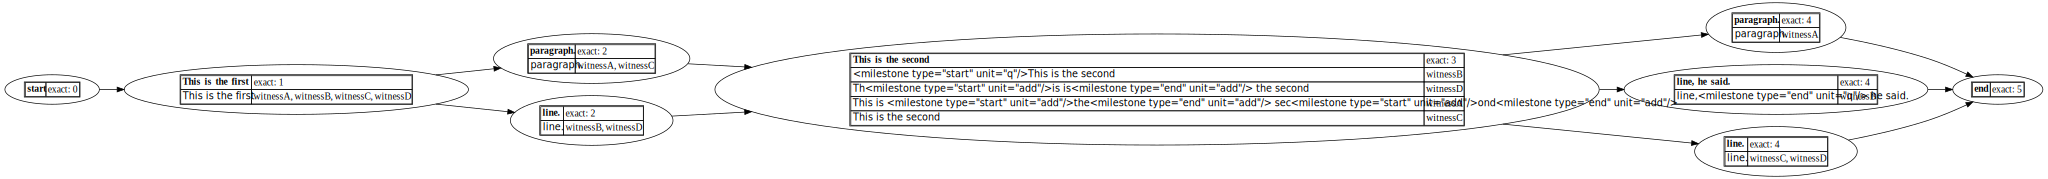

In [12]:
collate(collatex_json_input, output="svg")

We can turn off segmentation (grouping) to see each token in its own node.

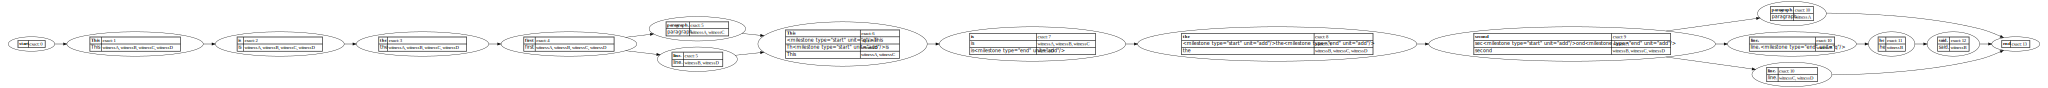

In [13]:
collate(collatex_json_input, segmentation=False, output="svg")

We can generate generic XML markup, suitable for an interlinear collation, and pretty-print it with:

In [14]:
xml_output = parseString(collate(collatex_json_input, output="xml"))
print(xml_output.toprettyxml())

<?xml version="1.0" ?>
<root>
	<app>
		<rdg wit="#witnessA">This is the first </rdg>
		<rdg wit="#witnessB">This is the first </rdg>
		<rdg wit="#witnessC">This is the first </rdg>
		<rdg wit="#witnessD">This is the first </rdg>
	</app>
	<app>
		<rdg wit="#witnessA">paragraph. </rdg>
		<rdg wit="#witnessB">line. </rdg>
		<rdg wit="#witnessC">paragraph. </rdg>
		<rdg wit="#witnessD">line. </rdg>
	</app>
	<app>
		<rdg wit="#witnessA">This is &lt;milestone type=&quot;start&quot; unit=&quot;add&quot;/&gt;the&lt;milestone type=&quot;end&quot; unit=&quot;add&quot;/&gt; sec&lt;milestone type=&quot;start&quot; unit=&quot;add&quot;/&gt;ond&lt;milestone type=&quot;end&quot; unit=&quot;add&quot;/&gt; </rdg>
		<rdg wit="#witnessB">&lt;milestone type=&quot;start&quot; unit=&quot;q&quot;/&gt;This is the second </rdg>
		<rdg wit="#witnessC">This is the second </rdg>
		<rdg wit="#witnessD">Th&lt;milestone type=&quot;start&quot; unit=&quot;add&quot;/&gt;is is&lt;milestone type=&quot;end&quot; unit=&quo

The output looks like:

```xml
<root>
    <app>
        <rdg wit="#witnessA">This is the first </rdg>
        <rdg wit="#witnessB">This is the first </rdg>
        <rdg wit="#witnessC">This is the first </rdg>
        <rdg wit="#witnessD">This is the first </rdg>
    </app>
    <app>
        <rdg wit="#witnessA">paragraph. </rdg>
        <rdg wit="#witnessB">line. </rdg>
        <rdg wit="#witnessC">paragraph. </rdg>
        <rdg wit="#witnessD">line. </rdg>
    </app>
    <app>
        <rdg wit="#witnessA">This is &lt;milestone type="start" unit="add"/&gt;the&lt;milestone
            type="end" unit="add"/&gt; sec&lt;milestone type="start" unit="add"/&gt;ond&lt;milestone
            type="end" unit="add"/&gt; </rdg>
        <rdg wit="#witnessB">&lt;milestone type="start" unit="q"/&gt;This is the second </rdg>
        <rdg wit="#witnessC">This is the second </rdg>
        <rdg wit="#witnessD">Th&lt;milestone type="start" unit="add"/&gt;is is&lt;milestone
            type="end" unit="add"/&gt; the second </rdg>
    </app>
    <app>
        <rdg wit="#witnessA">paragraph. </rdg>
        <rdg wit="#witnessB">line,&lt;milestone type="end" unit="q"/&gt; he said. </rdg>
        <rdg wit="#witnessC">line. </rdg>
        <rdg wit="#witnessD">line. </rdg>
    </app>
</root>
```